In [1]:
# 收在下布林，且下影線大於實體Ｋ及上影線，加入EMA
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1641014900000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

                Close_Time     Open    Close     High      Low      Volume
0      2022-01-01 14:59:59  3735.60  3711.92  3742.67  3708.33   5239.0026
1      2022-01-01 15:59:59  3711.93  3715.31  3724.93  3701.00   6541.6499
2      2022-01-01 16:59:59  3715.32  3721.40  3733.84  3708.60   4013.6403
3      2022-01-01 17:59:59  3721.14  3718.67  3730.00  3709.38   4515.6636
4      2022-01-01 18:59:59  3718.67  3691.39  3731.88  3673.46  10412.4737
...                    ...      ...      ...      ...      ...         ...
10821  2023-03-28 12:59:59  1711.65  1718.16  1718.17  1709.53  12827.8862
10822  2023-03-28 13:59:59  1718.16  1724.30  1724.31  1714.27  15892.4156
10823  2023-03-28 14:59:59  1724.31  1731.44  1735.93  1723.62  21886.5801
10824  2023-03-28 15:59:59  1731.44  1724.53  1734.05  1723.00  14031.4457
10825  2023-03-28 16:59:59  1724.54  1729.22  1729.30  1721.61   9584.1238

[10826 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
#     ema
    ema_int = 200
    df['ema'] = ta.trend.ema_indicator(df.Close, window=ema_int)
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema
0,2022-01-01 14:59:59,3735.60,3711.92,3742.67,3708.33,5239.0026,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 15:59:59,3711.93,3715.31,3724.93,3701.00,6541.6499,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 16:59:59,3715.32,3721.40,3733.84,3708.60,4013.6403,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01 17:59:59,3721.14,3718.67,3730.00,3709.38,4515.6636,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01 18:59:59,3718.67,3691.39,3731.88,3673.46,10412.4737,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10821,2023-03-28 12:59:59,1711.65,1718.16,1718.17,1709.53,12827.8862,1737.255000,1788.078501,1737.255000,1686.431499,43.645163,1748.321056
10822,2023-03-28 13:59:59,1718.16,1724.30,1724.31,1714.27,15892.4156,1735.602333,1784.751377,1735.602333,1686.453289,47.512464,1748.082041
10823,2023-03-28 14:59:59,1724.31,1731.44,1735.93,1723.62,21886.5801,1734.021333,1780.479144,1734.021333,1687.563523,51.666230,1747.916448
10824,2023-03-28 15:59:59,1731.44,1724.53,1734.05,1723.00,14031.4457,1732.728667,1777.997627,1732.728667,1687.459706,47.729487,1747.683747


In [9]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c1_1 紅Ｋ
    # c1_2 綠Ｋ
    # c2 收盤 小於 布林下
    # c3 ema 200

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (df['Open'] > df['Close']) & (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (df['Close'] > df['Open']) & (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']
        # c3
        df['c3'] = df['Close'] <= df['ema']

    # 條件達成
    df['signal'] = False
    df.loc[(df['c1_1'] | df['c1_2']) & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,c1_1,c1_2,c2,c3,signal,openbuy
0,2022-01-01 14:59:59,3735.60,3711.92,3742.67,3708.33,5239.0026,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,2022-01-01 15:59:59,3711.93,3715.31,3724.93,3701.00,6541.6499,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False
2,2022-01-01 16:59:59,3715.32,3721.40,3733.84,3708.60,4013.6403,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,2022-01-01 17:59:59,3721.14,3718.67,3730.00,3709.38,4515.6636,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False
4,2022-01-01 18:59:59,3718.67,3691.39,3731.88,3673.46,10412.4737,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,2023-03-28 12:59:59,1711.65,1718.16,1718.17,1709.53,12827.8862,1737.255000,1788.078501,1737.255000,1686.431499,43.645163,1748.321056,False,False,False,True,False,False
10822,2023-03-28 13:59:59,1718.16,1724.30,1724.31,1714.27,15892.4156,1735.602333,1784.751377,1735.602333,1686.453289,47.512464,1748.082041,False,False,False,True,False,False
10823,2023-03-28 14:59:59,1724.31,1731.44,1735.93,1723.62,21886.5801,1734.021333,1780.479144,1734.021333,1687.563523,51.666230,1747.916448,False,False,False,True,False,False
10824,2023-03-28 15:59:59,1731.44,1724.53,1734.05,1723.00,14031.4457,1732.728667,1777.997627,1732.728667,1687.459706,47.729487,1747.683747,False,False,False,True,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan

raw_entry_df = buydf.copy()

# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


                Close_Time     Open    Close     High      Low       Volume  \
224    2022-01-10 22:59:59  3021.34  3018.96  3041.82  2928.83  128141.5663   
225    2022-01-10 23:59:59  3018.96  3006.26  3032.40  2981.03   40379.5084   
226    2022-01-11 00:59:59  3006.27  3075.74  3095.00  2996.10   43620.2713   
250    2022-01-12 00:59:59  3133.55  3218.67  3237.22  3130.00   67296.1494   
299    2022-01-14 01:59:59  3301.24  3281.71  3304.33  3249.00   25448.0879   
...                    ...      ...      ...      ...      ...          ...   
10334  2023-03-08 04:59:59  1551.26  1548.20  1553.02  1543.10   22835.1524   
10335  2023-03-08 05:59:59  1548.20  1550.50  1555.18  1544.20   28465.7691   
10361  2023-03-09 07:59:59  1545.59  1532.38  1548.19  1523.61   58596.2112   
10808  2023-03-27 23:59:59  1719.75  1711.74  1721.00  1686.13  127541.0821   
10809  2023-03-28 00:59:59  1711.73  1717.42  1732.00  1708.17   53200.7526   

               sma         bb_u         bb_m       

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = df['position'].str.count('Sell').sum()
loses = df['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low          sma  \
0    2022-01-10 23:59:59  3018.96  3006.26  3032.40  2981.03  3130.832333   
1    2022-01-11 00:59:59  3006.27  3075.74  3095.00  2996.10  3129.797000   
2    2022-01-12 00:59:59  3133.55  3218.67  3237.22  3130.00  3087.766000   
3    2022-01-14 02:59:59  3281.40  3270.59  3296.49  3265.98  3350.109667   
4    2022-01-14 04:59:59  3271.49  3275.81  3278.73  3233.43  3343.479000   
..                   ...      ...      ...      ...      ...          ...   
275  2023-03-04 02:59:59  1572.16  1559.82  1573.38  1550.75  1594.821667   
276  2023-03-05 05:59:59  1557.65  1557.07  1560.64  1549.27  1566.469333   
277  2023-03-05 09:59:59  1570.15  1582.11  1588.77  1567.70  1566.939333   
278  2023-03-08 05:59:59  1548.20  1550.50  1555.18  1544.20  1565.976667   
279  2023-03-09 07:59:59  1545.59  1532.38  1548.19  1523.61  1554.823000   

            bb_u         bb_l        rsi position  entry_p  stop_loss  size

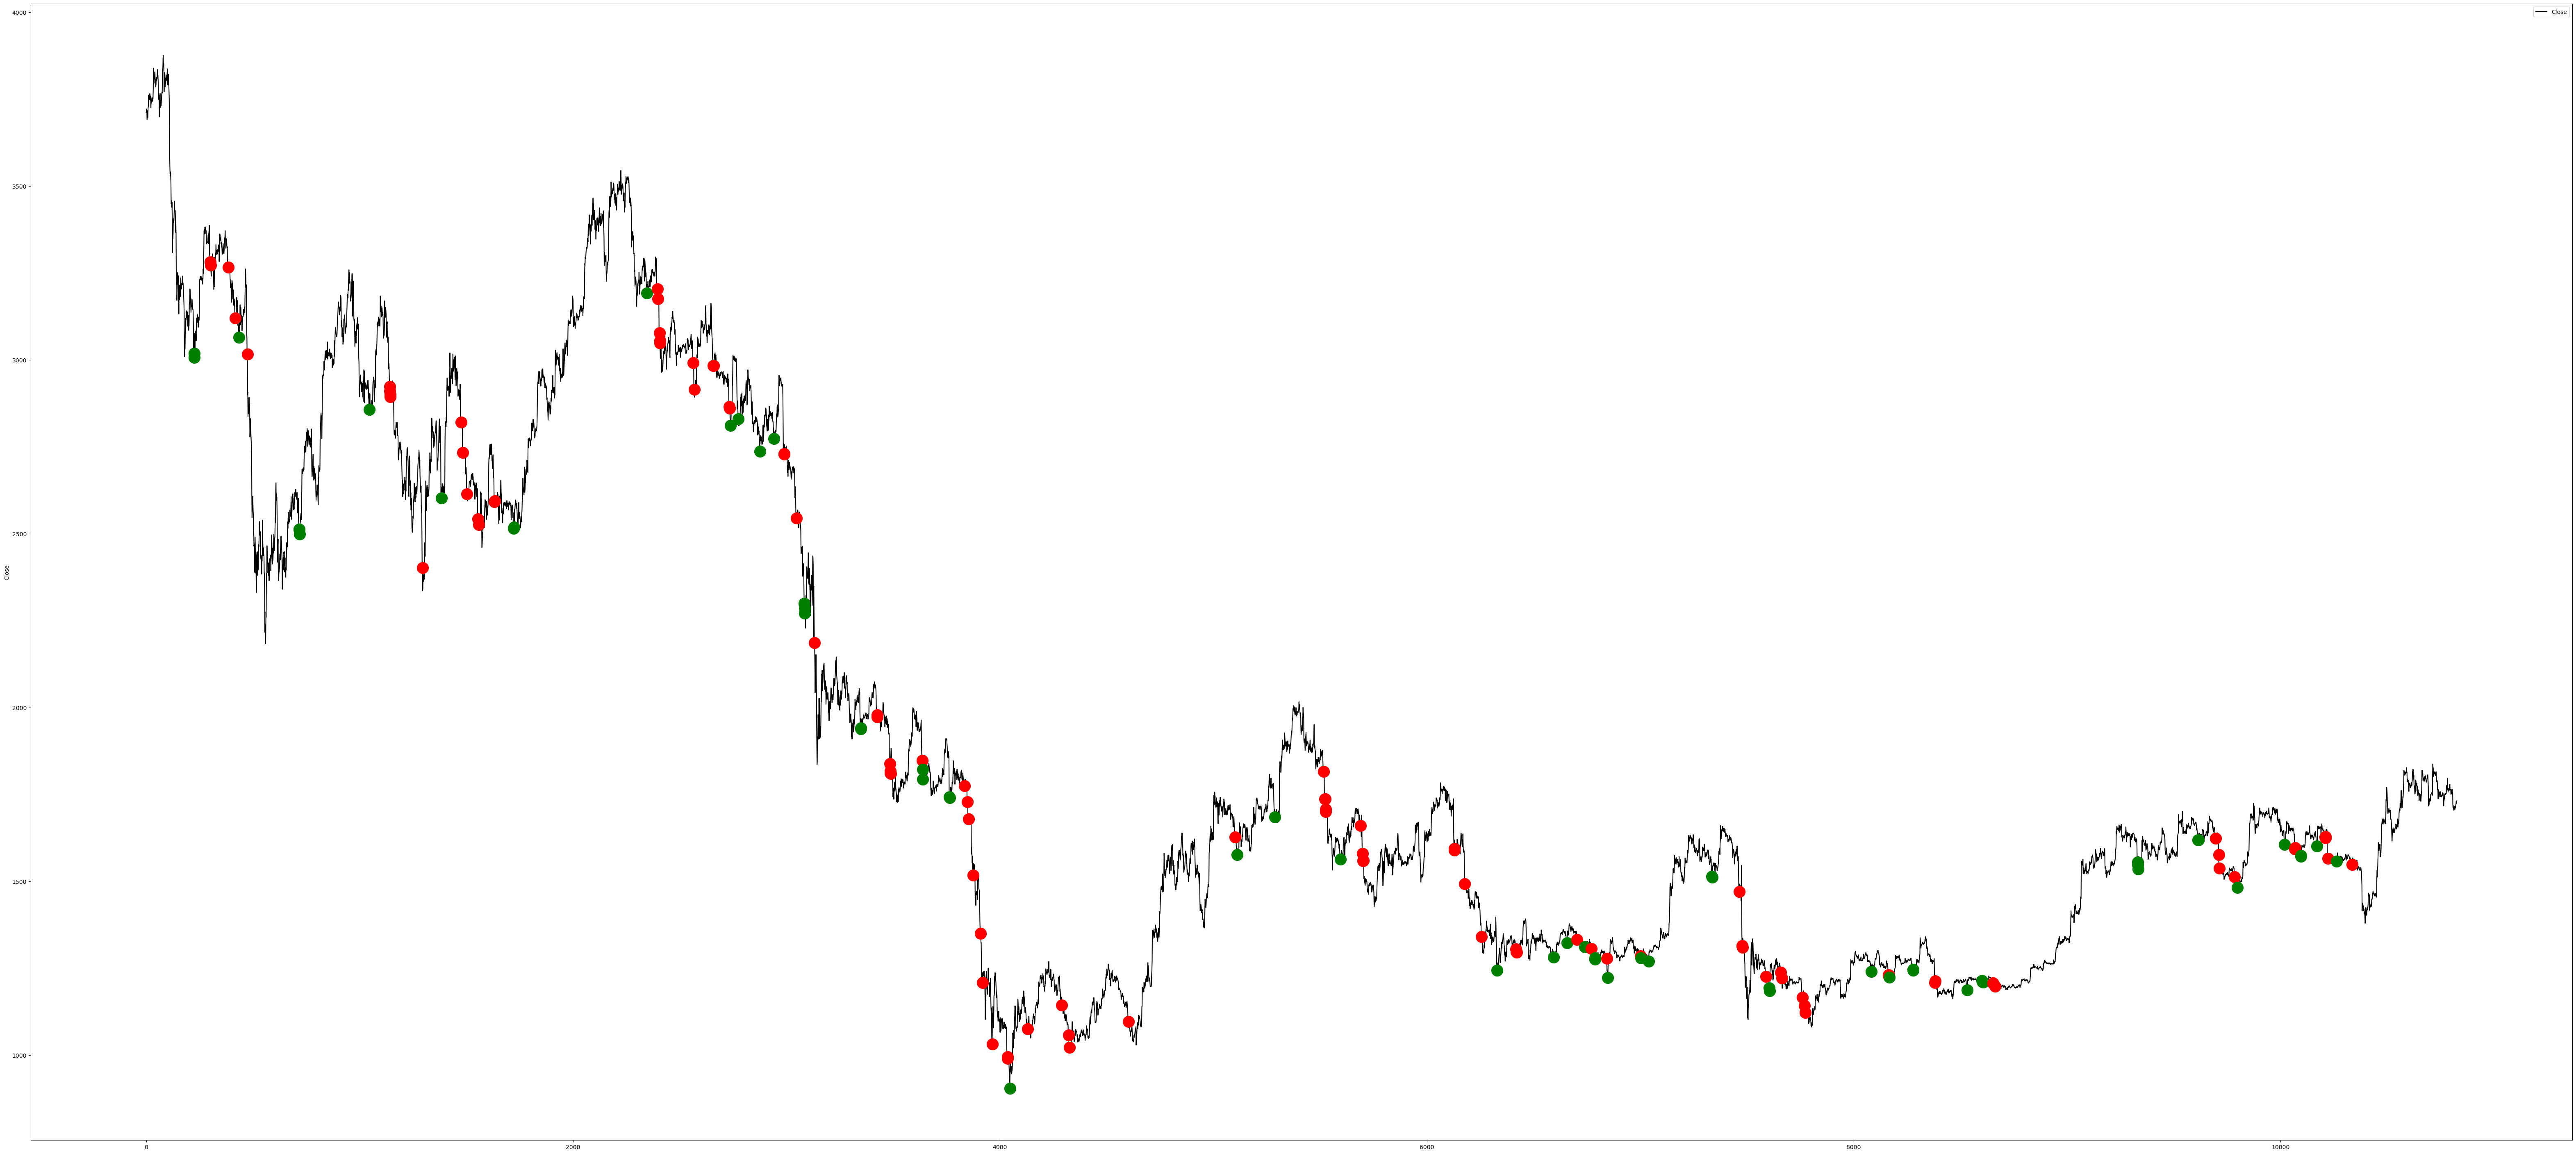

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位